# Introduction

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project

# Data Scraping

Scraping data from wikipedia using beautiful soup

In [4]:
#importing required libraries


import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Extraction from WikiPedia

In [5]:
#extracting data from wikipage

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text 
html_parsed_result = BeautifulSoup(text_result, 'html.parser') 

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

## Forming a pandas dataframe

In [6]:

neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


# EDA and Cleaning Data


The data has a lot of missing ("Not assigned") boroughs and neighbourhoods

In [8]:
#making a list a of all not assigned boroughs and neighbourhoods

not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighbourhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

In [9]:
#The rows with "Not assigned" Boroughs will be eliminated

neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [12]:
#The "Not assigned" values in the Neighborhood column will be replace with the Borough name in that cell

not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighbourhood'] == 'Not assigned'] 
for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighbourhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [14]:
# Postal codes can be clubbed to reduce data set


group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighbourhood']

grouped_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


## Retrieving postal codes coordinates

In [22]:
#downloading coordinate files
toronto_geocsv = 'https://cocl.us/Geospatial_data'
geocsv_data = pd.read_csv(toronto_geocsv)
geocsv_data.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
#To add the coordinates to the neighborhood dataframe, a join is performed using the postcodes as keys
postcodes_with_coordinates_df = grouped_df.join(geocsv_data.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(16)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [24]:

toronto_neighborhoods.shape

(103, 5)

## Visualizing the coordinates on MAP through Folium

In [26]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighbourhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

In [27]:
#Loading up foursquare credentials

CLIENT_ID = 'JPPMYJDFRHA30ZJ3T0Q3UQSBAP4DNGW3NOQG2FDTXBPJ1EVB' # your Foursquare ID
CLIENT_SECRET = 'N01JUHUV1SIKI3KOSZO00UWVQNUJLPJR3NJ3MDDXIS35VMXB' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JPPMYJDFRHA30ZJ3T0Q3UQSBAP4DNGW3NOQG2FDTXBPJ1EVB
CLIENT_SECRET:N01JUHUV1SIKI3KOSZO00UWVQNUJLPJR3NJ3MDDXIS35VMXB


In [29]:
!pip install geopy


  Created wheel for geographiclib: filename=geographiclib-1.49-cp37-none-any.whl size=35862 sha256=4560afb021cf499c5e22c6be0c921b33c709c4a78247d8f66ad06b6c2a2f8a13
  Stored in directory: C:\Users\HP\AppData\Local\pip\Cache\wheels\99\45\d1\14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [30]:
#Creating distance column to calculate the radius

from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [32]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(15)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


In [33]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

# 1.) Getting the Neighbourhood Venues

In [34]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [35]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=JPPMYJDFRHA30ZJ3T0Q3UQSBAP4DNGW3NOQG2FDTXBPJ1EVB&client_secret=N01JUHUV1SIKI3KOSZO00UWVQNUJLPJR3NJ3MDDXIS35VMXB&ll=43.7635726,-79.1887115&v=20180604&radius=1205.0&limit=100'

In [36]:

#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [37]:
venues_df = get_venues(url)

venues_df.head()


,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bc366dab492d13a51b2a860-0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'label': 'display', 'lat': 43.76875171771289...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b3a9504f964a520646a25e3-1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'label': 'display', 'lat': 43.77146181777272...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ba164fdf964a52039b337e3-2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'label': 'display', 'lat': 43.77134173380578...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c9fdb04542b224bca4201a0-3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'label': 'display', 'lat': 43.76904597684398...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b6074e3f964a5200fe729e3-4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4b6074e3f964a5200fe729e3,4410 Kingston Rd,CA,Scarborough,Canada,NaN,469,"[4410 Kingston Rd, Scarborough ON M1E 2N5, Can...","[{'label': 'display', 'lat': 43.76769708292701...",43.767697,-79.189914,M1E 2N5,ON,Swiss Chalet Rotisserie & Grill,0,[]


In [38]:

#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.767697,-79.189914,Swiss Chalet Rotisserie & Grill


In [39]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

In [40]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Liquor Store,43.771462,-79.184384,LCBO
2,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
5,Smoothie Shop,43.770668,-79.184150,Booster Juice
6,Coffee Shop,43.770367,-79.186313,Starbucks
7,Breakfast Spot,43.772319,-79.184900,Sunset Grill
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart


Now getting Postal Codes of all venues

In [41]:

#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [43]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postcode'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3309


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
2,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
3,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
4,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
5,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
6,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
7,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
8,M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store
9,M1B,43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant


# 2.) Segment the Neighbourhoods

In [44]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,37,1698
1,M1C,7,1625
2,M1E,27,1205
3,M1G,4,913
4,M1H,22,913
5,M1J,24,1301
6,M1K,22,1112
7,M1L,31,1052
8,M1M,18,1112
9,M1N,18,1297


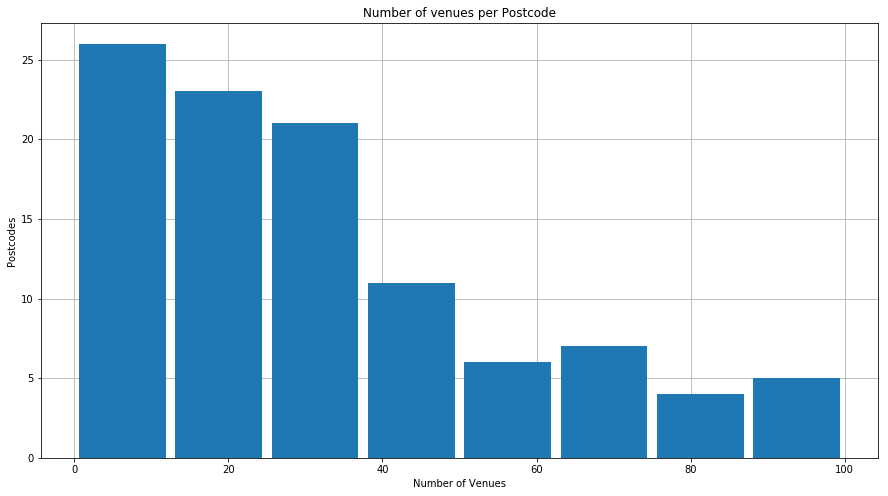

In [47]:
#Venue Frequency Distribution per Post Code

import matplotlib.pyplot as plt
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

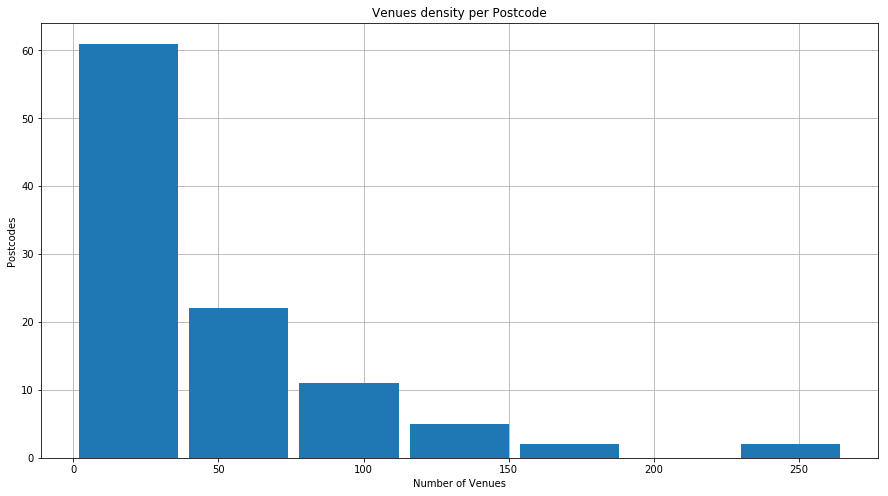

In [48]:
#in terms of density since the radius is different for all venues


density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()

# 3.) Clustering the Neighbourhoods

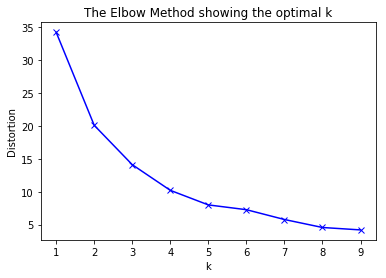

In [51]:
# finding the optimal number of clusters (k) for getting the neighbourhoods

from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [52]:
# Optimal No. of clusters = 5


num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 4 0 0 4 4 4 4 4 4 0 0 4 0 0 0 3 0 0 4 0 4 4 0 0 0 0 0 0 0 0
 3 3 4 4 1 4 1 0 0 4 4 0 3 0 3 2 3 2 3 3 1 2 3 1 4 0 0 4 4 2 4 3 3 4 0 0 0
 4 4 1 3 0 0 4 3 3 3 0 4 4 0 4 4 0 4 0 0 0 0 0 0 0 0 0 0 0]


In [53]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,Postcode,Density,Distance,Cluster
0,M1B,21,1698.0,0
1,M1C,4,1625.0,0
2,M1E,22,1205.0,0
3,M1G,4,913.0,0
4,M1H,24,913.0,0
5,M1J,18,1301.0,0
6,M1K,19,1112.0,0
7,M1L,29,1052.0,4
8,M1M,16,1112.0,0
9,M1N,13,1297.0,0


In [55]:
# Examining the clusters
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,14,50
1,4,41,29
2,3,85,15
3,1,130,5
4,2,218,4



Based on the centroids of each cluster, the cluster names can be defined as:

    1. 'Low Venues Density': Centroid equal to 14
    2. 'Medium-Low Venues Density' with a centroid equal to 41
    3. 'Medium-High Venues Density' with a centroid equal to 85
    4. 'High Venues Density' with a centr0id equal to 130
    5. 'Very High Venues Density' with a centroid equal to 218

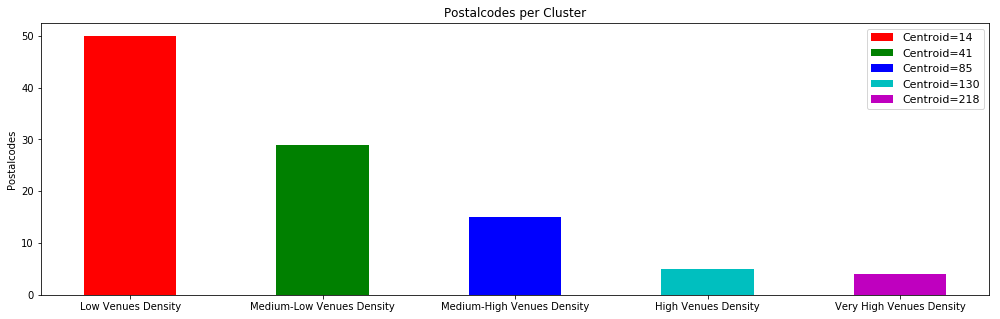

In [56]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postalcodes')
ax.set_title('Postalcodes per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()

In [57]:
#Visualising the clusters on map

postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map